# Import Library

In [8]:
import numpy as np  #import numpy 
import pandas as pd #import pandas
import matplotlib.pyplot as plt
import seaborn as sns


# Brief Exploration 

The initial code cell serves the purpose of loading the energy prices data into a pandas dataframe. Subsequently, I will display the dataframe to gain a better understanding of its contents.

In [3]:
brooklynHomeSalesDataset = pd.read_csv("brooklyn_sales_map.csv")
print(brooklynHomeSalesDataset.head(10))

C:\Users\Abillou\AppData\Local\Temp\ipykernel_43256\3302737305.py:1: DtypeWarning: Columns (40,41,43,45,46,47,86) have mixed types. Specify dtype option on import or set low_memory=False.
  brooklynHomeSalesDataset = pd.read_csv("brooklyn_sales_map.csv")


   Unnamed: 0  borough           neighborhood  \
0           1        3     DOWNTOWN-METROTECH   
1           2        3  DOWNTOWN-FULTON FERRY   
2           3        3       BROOKLYN HEIGHTS   
3           4        3             MILL BASIN   
4           5        3       BROOKLYN HEIGHTS   
5           6        3     WILLIAMSBURG-SOUTH   
6           7        3       BROOKLYN HEIGHTS   
7           8        3     WILLIAMSBURG-NORTH   
8           9        3     WILLIAMSBURG-SOUTH   
9          10        3              NAVY YARD   

             building_class_category tax_class  block   lot  easement  \
0              28  COMMERCIAL CONDOS         4    140  1001       NaN   
1             29  COMMERCIAL GARAGES         4     54     1       NaN   
2               21  OFFICE BUILDINGS         4    204     1       NaN   
3                22  STORE BUILDINGS         4   8470    55       NaN   
4                    26 OTHER HOTELS         4    230     1       NaN   
5         31  COMMERCI


For a brief exploration of this dataset, my initial step was to calculate both the total number of rows and columns, as well as the number of categorical variables, in the dataframe. Since the dataset is parsed through a Panda Dataframe, categorical variables are often represented as 'object' dtype, hence we need to count the columns with the dtype of object.

In [16]:
rows, cols = brooklynHomeSalesDataset.shape #Get the Shape of the Dataframe
print(f"Number of Rows: {rows}") 
print(f"Number of Columns: {cols}") 

categorical_columns = brooklynHomeSalesDataset.select_dtypes(include='object').columns
num_categorical_variables = len(categorical_columns)

print(f'The Number of Categorical Columns: {num_categorical_variables}')

Number of Rows: 390883
Number of Columns: 111
The Number of Categorical Columns: 36


The dataframe encompasses a total of 390,883 rows, signifying data representation for 390,883 properties in Brooklyn. With 111 columns with 36 of them being categorical, each property is associated with 111 distinct fields of information of which 36 are categorical. While navigating through this extensive set of fields may seem overwhelming, a helpful glossary of the data is provided in the code file for reference. Upon printing the dataframe, I observed several columns with entirely missing values (NA). Consequently, I aim to investigate the count of NA values within each respective field.

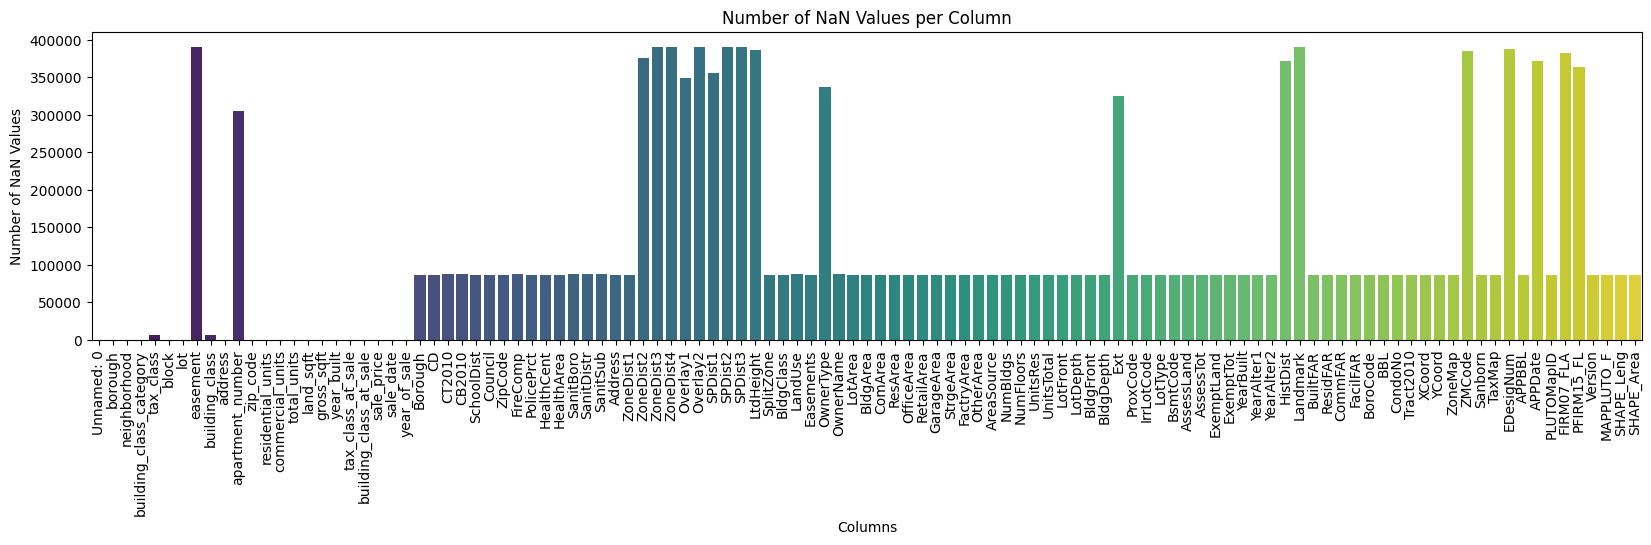

In [17]:
nan_counts = brooklynHomeSalesDataset.isna().sum()

# Set up the plot
plt.figure(figsize=(20, 4))
sns.barplot(x=nan_counts.index, y=nan_counts.values, hue=nan_counts.index, palette="viridis", dodge=False)

# Customize the plot
plt.title('Number of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

Evidently, certain columns exhibit an overwhelming abundance of NA values, rendering meaningful analysis and insights unlikely. Consequently, it might be prudent to consider removing some of these columns from the dataframe. One line aspect I'd like to explore in this dataset aligns with the goal of predicting house sale prices in Brooklyn. It would be insightful to create a scatterplot depicting the distribution of house sale prices over the years, allowing for the identification of any potential outliers.

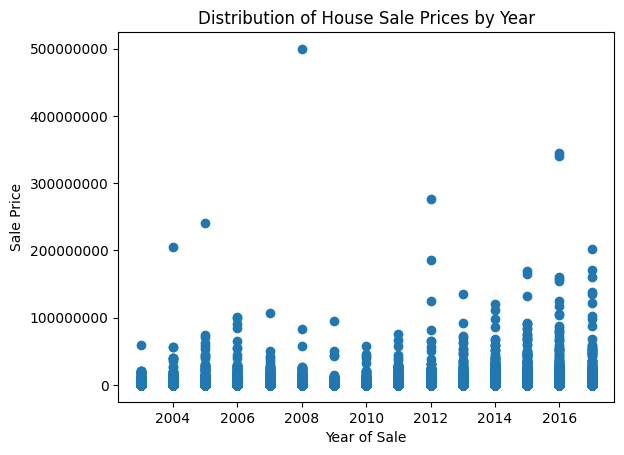

In [20]:
# Scatter plot of house sale prices against the year of sale
plt.scatter(x=brooklynHomeSalesDataset['year_of_sale'], y=brooklynHomeSalesDataset['sale_price'])

# Get the current Axes instance
ax = plt.gca()

# Disable scientific notation on the y-axis
ax.get_yaxis().get_major_formatter().set_scientific(False)

# Draw the plot
plt.xlabel('Year of Sale')
plt.ylabel('Sale Price')
plt.title('Distribution of House Sale Prices by Year')
plt.show()

It's quite intriguing to note that there are some apparent outliers in the data, particularly highlighted by a property sale record surpassing the $5 million mark! Delving deeper into understanding these outliers, I believe it would be beneficial to explore the statistical aspects of the data.

In [21]:
brooklynHomeSalesDataset['sale_price'].describe().apply(lambda x: format(x, 'f'))

count       390883.000000
mean        506754.477693
std        2353964.664225
min              0.000000
25%              0.000000
50%         275000.000000
75%         593000.000000
max      499401179.000000
Name: sale_price, dtype: object

Significantly, the 25th percentile of house sales indicated a price of $0. This anomaly could stem from recording errors or instances where property was transferred between parties, possibly through inheritance or similar circumstances. Operating under this assumption, it seems prudent to exclude these entries from my analysis, as they may not contribute meaningfully. Additionally, given the presence of apparent outliers in the data, it is advisable to remove them. When employing regression models, utilizing both normal and outlier data may introduce distortions, justifying the exclusion of outliers for a more accurate analysis.

# Pre-Processing

After examining the data, it became evident that the optimal approach is to eliminate columns predominantly filled with NA values and outliers. This step is crucial for enhancing the robustness of our analysis. Subsequently, considering the insights gained from the preceding plot, it appears beneficial to discard columns in which 75% of the values are missing.

In [22]:
# Set a threshold for column retention based on 75% non-null values
threshold = len(brooklynHomeSalesDataset) * 0.75

# Drop columns with missing values exceeding the threshold
brooklynHomeSalesDataset.dropna(thresh=threshold, axis=1, inplace=True)



Additionally, it would be beneficial to eliminate redundant columns that do not contribute valuable information or duplicate data already present in other columns.

In [27]:
brooklynHomeSalesDataset = brooklynHomeSalesDataset.drop(['APPBBL','BoroCode','Borough','BBL','PLUTOMapID','YearBuilt','CondoNo','BuiltFAR','FireComp','MAPPLUTO_F','Sanborn','SanitBoro','Unnamed: 0','Version', 'block','borough','Address','OwnerName','zip_code'],axis=1)

*note to self write your justifications of why you drop these in the moring.

To handle outliers, we compute the interquartile range (IQR) to establish both the upper and lower bounds for identifying outlier prices among the sale prices. Following this, we filter the dataset, removing data points that fall beyond these bounds, thus refining the dataset by excluding potential outliers.

In [28]:
# Calculate the first quartile (Q1)
first_quartile = brooklynHomeSalesDataset["sale_price"].quantile(0.25)

# Calculate the third quartile (Q3)
third_quartile = brooklynHomeSalesDataset["sale_price"].quantile(0.75)

# Calculate the interquartile range (IQR)
iqr = third_quartile - first_quartile

# Define the lower and upper bounds for outlier detection
lower_bound = first_quartile - (1.5 * iqr)
upper_bound = third_quartile + (1.5 * iqr)

# Filter the dataset to remove outliers based on sale prices
brooklynHomeSalesDataset = brooklynHomeSalesDataset.loc[
    (brooklynHomeSalesDataset["sale_price"] > lower_bound) & 
    (brooklynHomeSalesDataset["sale_price"] < upper_bound)
]


After removing columns with predominantly missing values, I still faced the challenge of handling significant gaps in other columns, ranging from a few thousand to over 80,000 missing entries. Determining the appropriate strategy for addressing these gaps involved thoughtful decisions.

In certain columns like ZipCode, School District, Police Precinct, Sanitation District, X and Y coordinates, I found it more sensible to fill missing values with the mode. Despite their numerical representation, these values are essentially categorical, and using the median would not provide meaningful insights.

Conversely, in some instances, filling missing values with zero made more sense. For instance, if the year of property alterations was unavailable, assuming no alterations had been carried out seemed a logical choice.

For categorical columns, I opted to fill missing data with the mode, while for other numerical variables, I employed a common approach by imputing missing values with the median. This comprehensive strategy ensures a nuanced and suitable handling of missing data across various types of variables in the dataset.

In [ ]:
# If basement data is missing, assuming the apartment/building is unknown (represented by the number 5)
brooklynHomeSalesDataset['BsmtCode'] = brooklynHomeSalesDataset['BsmtCode'].fillna(5)

# Community Area - not applicable or available if NA
columns_to_fill_with_zero = ['ComArea', 'CommFAR', 'FacilFAR', 'FactryArea', 'RetailArea', 'ProxCode', 'YearAlter1', 'YearAlter2']
brooklynHomeSalesDataset[columns_to_fill_with_zero] = brooklynHomeSalesDataset[columns_to_fill_with_zero].fillna(0)

# Filling missing values for categorical columns with the mode
columns_to_fill_with_mode = ['XCoord', 'YCoord', 'ZipCode', 'LotType', 'SanitDistr', 'HealthArea', 'HealthCent', 'PolicePrct',
                             'SchoolDist', 'tax_class_at_sale', 'CD', 'Council']
brooklynHomeSalesDataset[columns_to_fill_with_mode] = brooklynHomeSalesDataset[columns_to_fill_with_mode].apply(lambda x: x.fillna(x.mode()[0]))

# Impute missing values for numerical variables with the median
numerical_columns = brooklynHomeSalesDataset.select_dtypes(include=[np.number]).columns
brooklynHomeSalesDataset[numerical_columns] = brooklynHomeSalesDataset[numerical_columns].fillna(brooklynHomeSalesDataset[numerical_columns].median())
